# Demodulación FM de muestras IQ de RTL-SDR v3

In [1]:
# Requiere instalar pyrtlsdr (Solo RTL-SDR v3 soportado por el momento)
# https://github.com/roger-/pyrtlsdr
from rtlsdr import RtlSdr

import time
import numpy as np  
import scipy.signal as signal
from scipy.io import wavfile
from typing import List
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
F_station = int(137.5e6)   # Frecuencia de la estación transmisora
F_offset = 0       # Desplazamiento para capturar en  
# Capturamos en un offset para evitar picos de CC (DC)
Fc = F_station - F_offset # Captura de la frecuencia central  
Fs = int(0.230e6)         # Frecuencia de muestreo  

sdr = RtlSdr()
# Configurar dispositivo
sdr.sample_rate = Fs      # Hz  
sdr.center_freq = Fc      # Hz  
sdr.gain = 'auto'
sdr.bw = 115e3
all_samples = []
async def streaming(sdr: RtlSdr, time_s: int) -> List[np.ndarray]:
    # all_samples = []
    global all_samples
    t_before = time.time()
    print("Recepcionando muestras...")
    async for samples in sdr.stream():
        all_samples.append(samples)
        if time.time() - t_before >= time_s:
            break
    # configurar dispositivo
    await sdr.stop()
    sdr.close()
    return all_samples


In [48]:
# Leer muestras hasta que pase cierto tiempo
tiempo_a_recepcionar = 230  # Tiempo en segundos

samples = await streaming(sdr, tiempo_a_recepcionar)

print('Listo!')

Listo!


In [49]:
# Limpiar el dispositivo SDR
sdr.close()
del(sdr)

In [4]:
# Convertir muestras en una matriz numpy
x1 = np.array(all_samples).ravel().astype("complex64")

In [5]:
# Guarda muestras I/Q
x1.tofile("./Files_Rx/IQ.raw")

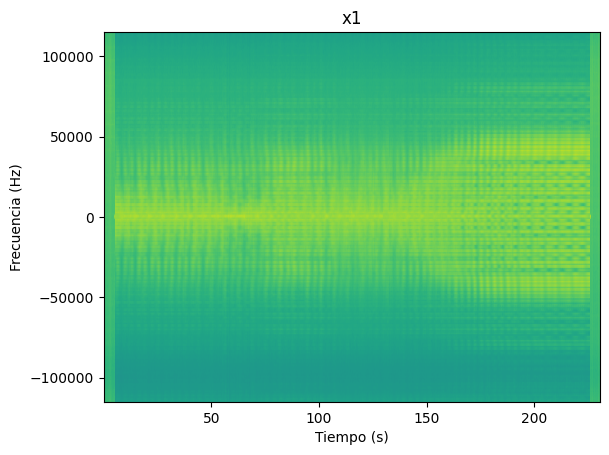

In [25]:
plt.figure()
plt.specgram(x1, NFFT=256, Fs=Fs)  
plt.title("x1")  
plt.xlabel("Tiempo (s)")  
plt.ylabel("Frecuencia (Hz)") 
plt.ylim(-Fs/2, Fs/2)  
plt.show()

In [7]:
# Para mezclar los datos hacia abajo, generar una exponencial compleja digital 
# (con la misma longitud que x1) con fase -F_offset/Fs
fc1 = np.exp(-1.0j*2.0*np.pi* F_offset/Fs*np.arange(len(x1)))

# Ahora, basta con multiplicar x1 y el exponencial complejo digital
x2 = x1 * fc1  

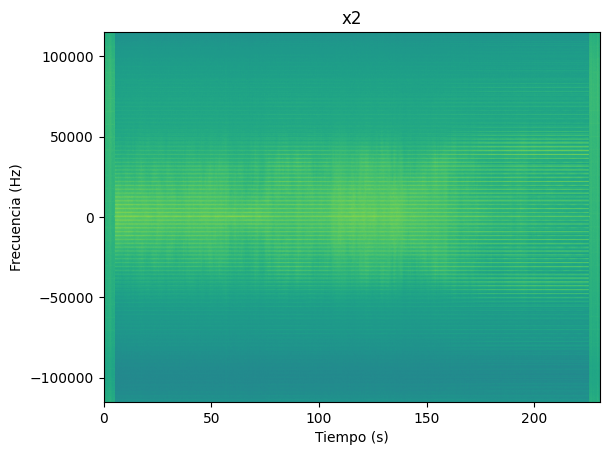

In [8]:
plt.specgram(x2, NFFT=2048, Fs=Fs)  
plt.title("x2")  
plt.xlabel("Tiempo (s)")  
plt.ylabel("Frecuencia (Hz)")  
plt.ylim(-Fs/2, Fs/2)  
plt.xlim(0,len(x2)/Fs)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()

In [9]:
# Una señal de radiodifusión en FM tiene un ancho de banda de 200 kHz.
f_bw = 115000  # 115 KHz para APT_Tx
dec_rate = int(Fs / f_bw)  
x4 = signal.decimate(x2, dec_rate)  
# Calcular la nueva frecuencia de muestreo
Fs_y = Fs/dec_rate  

In [13]:
print(f"La nueva frecuencia de muestreo es {Fs_y/1e3} KHz")

La nueva frecuencia de muestreo es 115.0 KHz


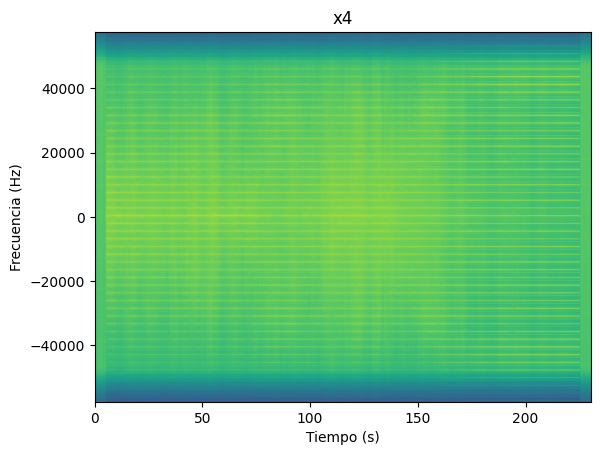

In [26]:
plt.specgram(x4, NFFT=2048, Fs=Fs_y)  
plt.title("x4")  
plt.xlabel("Tiempo (s)")  
plt.ylabel("Frecuencia (Hz)") 
plt.ylim(-Fs_y/2, Fs_y/2)  
plt.xlim(0,len(x4)/Fs_y)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()

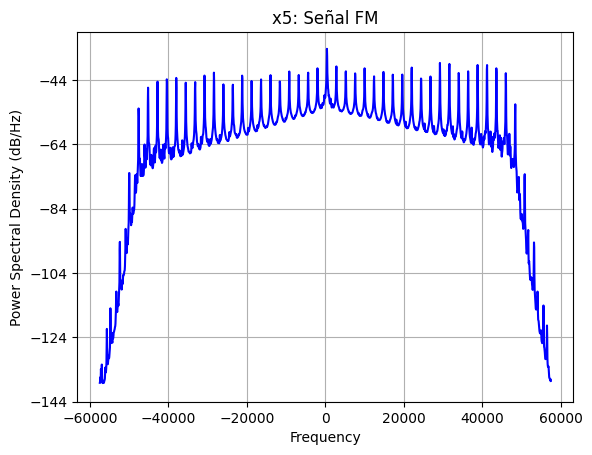

In [47]:
# Grafica el espectro en frecuencia con la FFT de x4.
plt.psd(x4, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x5: Señal FM")  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show() 

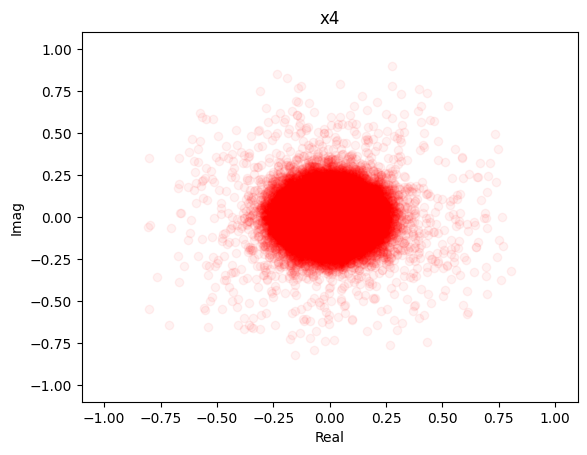

In [15]:
# Grafica la constelación de x4.
plt.scatter(np.real(x4[0:50000]), np.imag(x4[0:50000]), color="red", alpha=0.05)  
plt.title("x4")  
plt.xlabel("Real")  
plt.xlim(-1.1,1.1)  
plt.ylabel("Imag")  
plt.ylim(-1.1,1.1)  
plt.show()

In [16]:
### Discriminador polar
## Demodular FM
y5 = x4[1:] * np.conj(x4[:-1])  
x5 = np.angle(y5)  

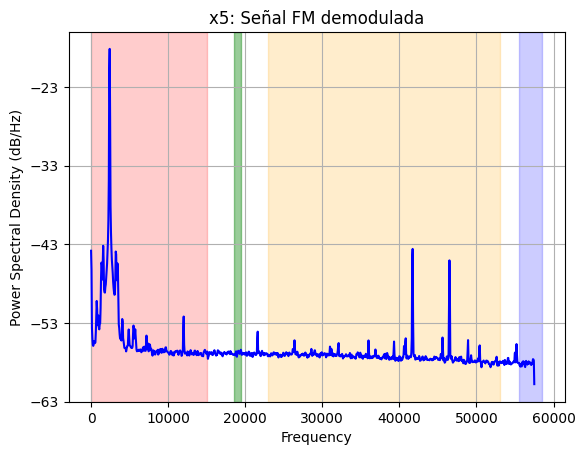

In [29]:
# Nota: x5 es ahora una matriz de valores reales, no complejos
# Como resultado, las PSD se trazarán por defecto en un solo lado (ya que
# una señal real tiene un espectro simétrico)
# Trazar la PSD de x5
plt.psd(x5, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x5: Señal FM demodulada")  
plt.axvspan(0, 15000, color="red", alpha=0.2)  
plt.axvspan(19000-500, 19000+500, color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500, 19000*3+1500, color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()  

# Se puede apreciar la subportadora en 2.4 KHz, que es justo de la señal APT modulada en AM
# Los colores son para distinguir de las señales FM comerciales, las cuales sí contienen información adicional.

In [18]:
# El filtro de desacentuación
# Dada una señal 'x5' (en un array numpy) con frecuencia de muestreo Fs_y
d = Fs_y * 75e-6   # Calcular el número de muestras para alcanzar el punto -3dB  
x = np.exp(-1/d)   # Calcular el decaimiento entre cada muestra  
b = [1-x]          # Crear los coeficientes del filtro  
a = [1,-x]  
x6 = signal.lfilter(b,a,x5)  

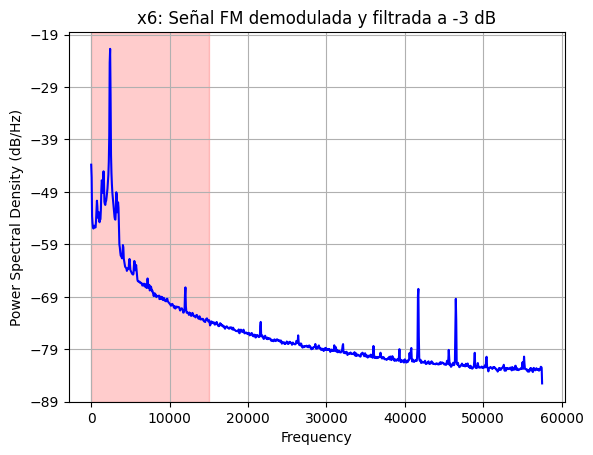

In [31]:
# Nota: x5 es ahora una matriz de valores reales, no complejos
# Como resultado, las PSD se trazarán por defecto en un solo lado (ya que
# una señal real tiene un espectro simétrico)
# Trazar la PSD de x5
plt.psd(x6, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x6: Señal FM demodulada y filtrada a -3 dB")  
plt.axvspan(0, 15000, color="red", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()  

# Se puede apreciar la subportadora en 2.4 KHz, que es justo de la señal APT modulada en AM

In [36]:
# Encuentra una tasa de decimación para conseguir una frecuencia de muestreo de audio entre 44-48 kHz
audio_freq = 44100.0  
dec_audio = int(Fs_y/audio_freq)  
Fs_audio = Fs_y / dec_audio

x7 = signal.decimate(x6, dec_audio)  

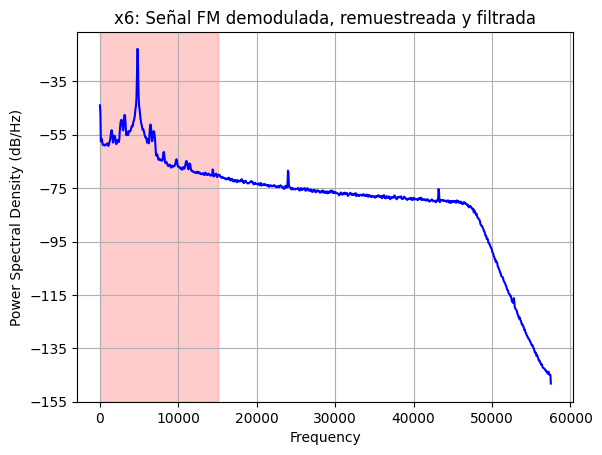

In [37]:
plt.psd(x7, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x6: Señal FM demodulada, remuestreada y filtrada")
plt.axvspan(0, 15000, color="red", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()  

In [38]:
print(f"Se ha remuestreado a {audio_freq/1e3} KHz")

Se ha remuestreado a 44.1 KHz


In [39]:
# Escala el audio para ajustar el volumen
x7 *= 10000 / np.max(np.abs(x7))  
# Guardar en archivo como muestras de audio monocanal con signo de 16 bits
# x7.astype("int16").tofile("./Files_Rx/wbfm-mono_Rx.raw")

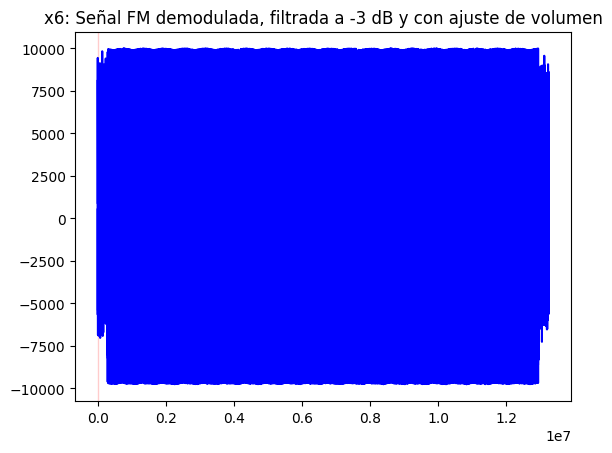

In [42]:
plt.plot(x7, color="blue")  
plt.title("x6: Señal FM demodulada, filtrada a -3 dB y con ajuste de volumen")
plt.axvspan(0, 15000, color="red", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()  

In [43]:
print(Fs_audio) 

57500.0


In [23]:
# Guardar como archivo de audio en formato 16-bit PCM RIFF WAV
output_path_WAV = './Files_Rx/audio_APT_Rx_pyfm.wav'
wavfile.write(output_path_WAV, int(Fs_audio), x7.astype("int16"))
print(f"Se ha guardado la señal FM demodulada en {output_path_WAV}")

Se ha guardado la señal FM demodulada en ./Files_Rx/audio_APT_Rx_pyfm.wav
